<a href="https://colab.research.google.com/github/ritzi12/Unsupervised/blob/main/fuzzyMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FUZZY MEANS CLUSTERING**


It is a soft clustering method wherein we don't assign cluster number to observations instead we assign **membership function** values to each cluster. This is known as **soft clustering** where we assign probability of belonging to a cluster instead of hard clustering.

This algorithm works by assigning membership to each data point corresponding to each cluster center on the basis

of distance between the cluster center and the data point. More the data is near to the cluster center more is its

membership towards the particular cluster center. Clearly, summation of membership of each data point should be equal to one.




## Load Libraries

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import scipy.spatial as sp
from random import randint

import warnings 
warnings.filterwarnings("ignore")

## Load Data

This is a sample fish dataset of dimension 85 observations and 6 features with 4 species of fish.



In [66]:
#Load the data 
df = pd.read_csv("/content/fish.csv",names = ["label","f1","f2","f3","f4","f5","f6"] , header=None)

display(df)

,label,f1,f2,f3,f4,f5,f6
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1
...,...,...,...,...,...,...,...
80,Pike,950.0,48.3,51.7,55.1,16.2,11.2
81,Pike,1250.0,52.0,56.0,59.7,17.9,11.7
82,Pike,1600.0,56.0,60.0,64.0,15.0,9.6
83,Pike,1550.0,56.0,60.0,64.0,15.0,9.6


### Preprocessing Data

* Split columns into features and Labels
* Scaling the features as there is lot of variance in features for example f1 feature has really large values which can impact the clustering 

In [62]:
X= df.drop(columns=["label"])
display(X)
Y = df["label"].astype("category").cat.codes #convert label as category and access category codes
print("\n Bream=0,Pike=1, Roach=2,Smelt=3")
print(Y[:5])


,f1,f2,f3,f4,f5,f6
0,242.0,23.2,25.4,30.0,38.4,13.4
1,290.0,24.0,26.3,31.2,40.0,13.8
2,340.0,23.9,26.5,31.1,39.8,15.1
3,363.0,26.3,29.0,33.5,38.0,13.3
4,430.0,26.5,29.0,34.0,36.6,15.1
...,...,...,...,...,...,...
80,950.0,48.3,51.7,55.1,16.2,11.2
81,1250.0,52.0,56.0,59.7,17.9,11.7
82,1600.0,56.0,60.0,64.0,15.0,9.6
83,1550.0,56.0,60.0,64.0,15.0,9.6



 Bream=0,Pike=1, Roach=2,Smelt=3
0    0
1    0
2    0
3    0
4    0
dtype: int8


In [8]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Fuzzy C Means Algorithm


Steps -- 
1. Randomly initialise any datapoints as cluster centers, also fuzzi index or parameter (m) which determines how much fuzzy is the dataset if m is high means an observation can belong to more number of clusters. 


2. Find euclidean distance || L2 norm|| for each datapoint from each cluster. Example if you have 2 clusters and 12 obs then distance matrix (12x2) dimension

3.  Find Membership Functions

4. Re-calculate new cluster centers.

5. Calculate the Objective function which we have to minimise.

6. Terminate the algorithm when change in old J and new J is < 0.001

c= number of clusters

n= number  of observations




Objective Funtion 

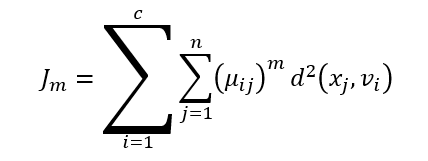

Membership Function

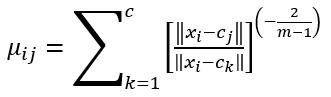

New Centers

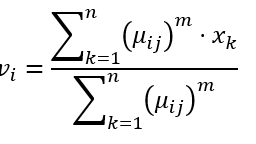

In [11]:
class fuzzyClust:
  
  def __init__(self, data, n_cluster, fuzzy_index = 2, init_random=True):
    self.data = data
    self.n_cluster = n_cluster
    self.fuzzy_index = fuzzy_index
    self.init_random = init_random
    self.mat_dist =np.zeros((len(self.data),self.n_cluster)) 
    self.mu_mat_norm = np.zeros((len(self.data),self.n_cluster))
    self.new_centers = np.zeros((self.n_cluster,self.data.shape[1]))
    self.mu_mat_norm_pow = 0
    self.obj_func_val = 0


  def init_centers(self):
    rng = np.random.default_rng()
    self.centers = rng.choice(self.data,self.n_cluster,axis=0) #elf.data[np.ix_([1,5],[0,1])]#


  def dist(self):
    
    for c in range(0,self.n_cluster):
       self.mat_dist[:,c] =sp.distance.cdist(self.data,[self.centers[c,:]],metric="euclidean").ravel()
    return self.mat_dist
  

  def mem_func(self):
    mu_mat = np.zeros((len(self.data),self.n_cluster))
    
    for c in range(0,self.n_cluster):
      mu_mat[:,c] = np.power(self.mat_dist[:,c]/np.sum(self.mat_dist,axis=1),(-2/self.fuzzy_index-1)).ravel()

    mu_mat = np.where(mu_mat==np.inf,0,mu_mat)
    for c in range(0,self.n_cluster):
      self.mu_mat_norm[:,c] = (mu_mat[:,c]/np.sum(mu_mat,axis=1)).ravel()

    self.mu_mat_norm_pow = np.power(self.mu_mat_norm,self.fuzzy_index)
    return self.mu_mat_norm


  def new_centers_func(self): 
    co_ord = lambda c,i: np.sum(np.divide(
        np.multiply(self.mu_mat_norm_pow[:,c],self.data[:,i]),
        np.sum(self.mu_mat_norm_pow[:,c])));
    
    data_dimen  = self.data.shape[1]

    for c in range(0,self.n_cluster):
      center = [co_ord(c,i) for i in range(0,data_dimen)]
      self.new_centers[c,:] = center
    return self.new_centers


  def obj_func(self):
    dist_sq = np.power(self.mat_dist,2)
    self.obj_func_val = np.sum(np.sum(np.multiply(self.mu_mat_norm_pow,dist_sq),axis=0))
    return self.obj_func_val


  def get_cluster_prob(self):
    self.init_centers();
    old_obj_func =0 ;

    for i in range(0,100):
      self.dist();
      self.mem_func();
      self.new_centers_func();
      new_obj_func = self.obj_func();
      if (old_obj_func - new_obj_func < 0.001 and i!=0):
        #print(old_obj_func - new_obj_func )
        break;
      else:
        old_obj_func = new_obj_func
        self.centers=self.new_centers
        self.num_of_iterations = i+1;
    return self.mu_mat_norm,new_obj_func,self.num_of_iterations


## Testing Algorithm for Sample Data

For testing the algorithm we will use a sampler simple dataset to understand the working of fuzzy clustering.

This dataset consists of 2 features and 12 observations.

In the plot below we can observe that observation 11th is in between two major cluster (X,Y) = (0,0) and  obs 12th is an outlier which belongs to neither of the cluster (X,Y) = (0,10)

In [15]:
sample_data  = pd.read_csv("fcm.csv")
sample_data

,Obs,X,Y
0,1,-5.00,0.00
1,2,-3.34,1.67
2,3,-3.34,0.00
3,4,-3.34,-1.67
4,5,-1.67,0.00
5,6,1.67,0.00
6,7,3.34,1.67
7,8,3.34,0.00
8,9,3.34,-1.67
9,10,5.00,0.00


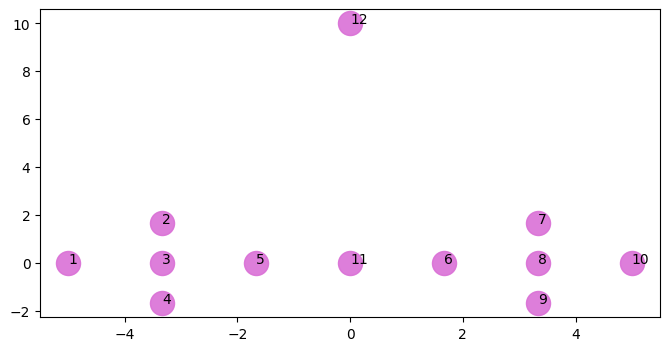

In [27]:
#Plot the sample data
plt.figure(figsize=(8,4))
scatter = plt.scatter(sample_data[["X"]],sample_data[["Y"]], c="orchid",s=300, alpha=0.9)

# Loop for annotation of all points to know relative positions of points
for i in range(len(sample_data)):
    plt.annotate(sample_data.loc[i,"Obs"], (sample_data.loc[i,"X"], sample_data.loc[i,"Y"]),fontsize=10,fontweight=0.5)

In [38]:
#applying the fuzzy c means algorithm with 2 clusters and data as input

fuzzy_obj = fuzzyClust(sample_data[["X","Y"]].values,n_cluster = 2);
mem_val , objective_func, num_of_iter  =  fuzzy_obj.get_cluster_prob();

print("Membership function values for two clusters\n",mem_val)
print("Cluster Centers : \n",fuzzy_obj.centers)
print("Final Objective Function Value which we are minimising  : \n",objective_func)
print("Iterations for convergence : \n",num_of_iter)

Membership function values for two clusters
 [[0.06369454 0.93630546]
 [0.03268483 0.96731517]
 [0.01036377 0.98963623]
 [0.10068739 0.89931261]
 [0.08438954 0.91561046]
 [0.91561046 0.08438954]
 [0.96731517 0.03268483]
 [0.98963623 0.01036377]
 [0.89931261 0.10068739]
 [0.93630546 0.06369454]
 [0.5        0.5       ]
 [0.5        0.5       ]]
Cluster Centers : 
 [[ 2.98528706  0.54356959]
 [-2.98528706  0.54356959]]
Final Objective Function Value which we are minimising  : 
 78.20721123944935
Iterations for convergence : 
 5


### Observations 

* We can see that 11th and 12th observation have 0.5 membership value for each cluster indicating neither of the cluster they belong to fully.
* Other observations have a clearly high value for one cluster and low for another cluster which is expected due to 2 clear cluster formation as sene in scatterplot

## Testing Algorithm for Fish Dataset

Now we apply the algorithm for fish dataset in 2 different ways:-

* Here we know labels of fish species so at first we apply for 2 features to understand the clustering mechanism in 2D

* Next, we apply it on all the 6 features.

In [50]:
obj= fuzzyClust(X_scaled[:,[1,4]],4)
mem_val , objective_func, num_of_iter  =  obj.get_cluster_prob();

print("Membership function values for 4 clusters\n",mem_val[:10,:])
print("Cluster Centers : \n",obj.centers)
print("Final Objective Function Value which we are minimising  : \n",objective_func)
print("Iterations for convergence : \n",num_of_iter)

Membership function values for 4 clusters
 [[0.05536462 0.03653581 0.22242125 0.68567832]
 [0.04225687 0.03047408 0.14968087 0.77758818]
 [0.04362048 0.03113407 0.15676555 0.7684799 ]
 [0.02374727 0.01977751 0.09688945 0.85958578]
 [0.03096545 0.02592714 0.14181128 0.80129613]
 [0.01548999 0.0135121  0.0572301  0.91376781]
 [0.01651502 0.01454611 0.05395255 0.91498633]
 [0.02590446 0.02384931 0.11808528 0.83216095]
 [0.00928335 0.00860044 0.03232871 0.9497875 ]
 [0.00454303 0.00449123 0.01614025 0.97482548]]
Cluster Centers : 
 [[-1.40860352 -1.07518797]
 [ 1.47700831 -1.18554711]
 [-0.56876428 -0.13914868]
 [ 0.28229023  1.11333848]]
Final Objective Function Value which we are minimising  : 
 12.449617190264602
Iterations for convergence : 
 11


### Plotting Clusters

Using only two dimensions for our fuzzy clustering algorithm to reduce complexity and gain better visualisation in 2D

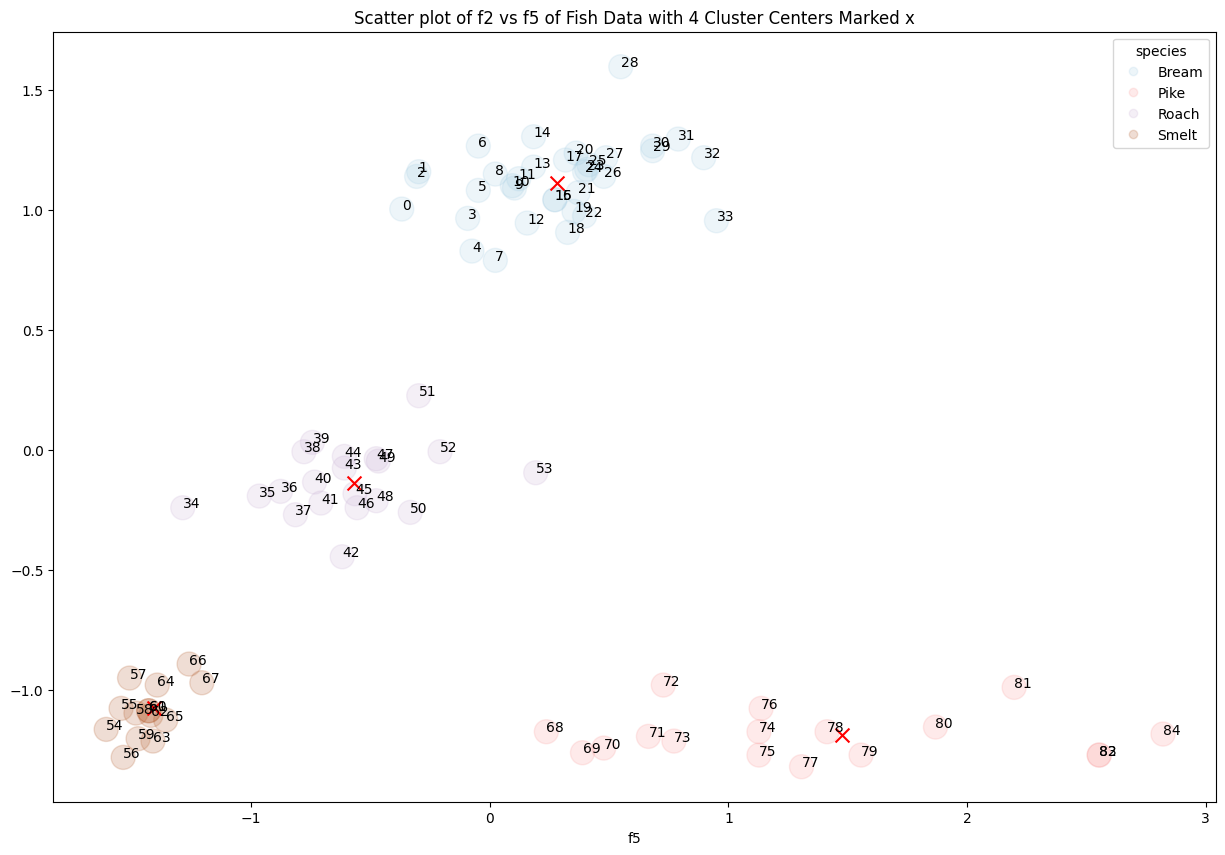

In [57]:
#Plot
ind = X.index.tolist()
plt.figure(figsize=(15,10))
scatter = plt.scatter(X_scaled[:,1],X_scaled[:,4],c=Y, cmap='Paired',s=300, alpha=0.2)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=["Bream","Pike","Roach","Smelt"],
           title="species")
plt.scatter(obj.centers[:,0],obj.centers[:,1],marker="x",s=100,c="red")
plt.title("Scatter plot of f2 vs f5 of Fish Data with 4 Cluster Centers Marked x")
plt.xlabel("f2")
plt.xlabel("f5")
# Loop for annotation of all points to know relative positions of points
for i in range(len(X)):
    plt.annotate(ind[i], (X_scaled[i,1], X_scaled[i,4]),fontsize=10,fontweight=0.3)


In [68]:
# Storing clusters in a dataframe 
df_dict = {"species":df['label'], "f2": X_scaled[:,1], "f5": X_scaled[:,4], "cluster":np.argmax(mem_val,axis=1) }
fish_df = pd.DataFrame(df_dict)

# comparing cross tabulation of species vs cluster
display(pd.crosstab(fish_df["species"],fish_df["cluster"]))

cluster,0,1,2,3
species,,,,
Bream,0,0,0,34
Pike,0,17,0,0
Roach,0,0,20,0
Smelt,14,0,0,0


### Observations 

We can see that our fuzzy means clustering gave an acucracy of 100 % and all 4 species we clustered appropriately since in the scatter plot of 2D f2 vs f5 we can see the 4 clusters are clearly distinct.

But when we use all the 6 features then that may not be the case since some datapoints may be overlapping due to high dimension.

### Using All 6 Features for Clustering

In [89]:
obj= fuzzyClust(X_scaled,4) #passing all 6 scaled features
mem_val , objective_func, num_of_iter  =  obj.get_cluster_prob();

print("Membership function values for 4 clusters\n",mem_val[:10,:])
print("Cluster Centers : \n",obj.centers)
print("Final Objective Function Value which we are minimising  : \n",objective_func)
print("Iterations for convergence : \n",num_of_iter)

Membership function values for 4 clusters
 [[0.3254469  0.53937684 0.0814242  0.05375206]
 [0.43611397 0.43933776 0.07025578 0.05429248]
 [0.45588275 0.43482825 0.05952445 0.04976455]
 [0.58663739 0.29920803 0.0567298  0.05742478]
 [0.62001965 0.29297458 0.04144084 0.04556493]
 [0.76131964 0.17045156 0.03158547 0.03664333]
 [0.74935607 0.17634226 0.0342534  0.04004828]
 [0.64934401 0.24867239 0.04656165 0.05542195]
 [0.79015119 0.14330556 0.03005448 0.03648878]
 [0.86586737 0.08720867 0.0197702  0.02715376]]
Cluster Centers : 
 [[ 0.598149    0.33411045  0.36108343  0.46382304  1.08088402  0.59734235]
 [-0.7137671  -0.56916303 -0.57188161 -0.58644704 -0.09077293  0.74516191]
 [-1.09073701 -1.41180188 -1.43669498 -1.50837009 -1.09384283 -1.35957943]
 [ 0.7967453   1.44777681  1.41021839  1.27364684 -1.16563067 -1.14570043]]
Final Objective Function Value which we are minimising  : 
 61.8722128144364
Iterations for convergence : 
 27


In [103]:
# Generating TSNE Components to visualise in 2 D plot
tsne=TSNE(n_components=2, learning_rate="auto", perplexity=40)
X_tsne = tsne.fit_transform(X_scaled)
scaler = StandardScaler()
X_tsne = scaler.fit_transform(X_tsne)

# tsne=TSNE(n_components=2, learning_rate="auto", perplexity=1)
# centers = tsne.fit_transform(obj.centers)
# scaler = StandardScaler()
# tsne_centers = scaler.fit_transform(centers)

# Storing clusters in a dataframe 
df_dict = {"species":df['label'],"tsne1":X_tsne[:,0],"tsne2":X_tsne[:,1],
           "cluster":np.argmax(mem_val,axis=1) }
fish_df = pd.DataFrame(df_dict)

# comparing cross tabulation of species vs cluster
display(pd.crosstab(fish_df["species"],fish_df["cluster"]))

cluster,0,1,2,3
species,,,,
Bream,32,2,0,0
Pike,0,0,0,17
Roach,0,20,0,0
Smelt,0,1,13,0


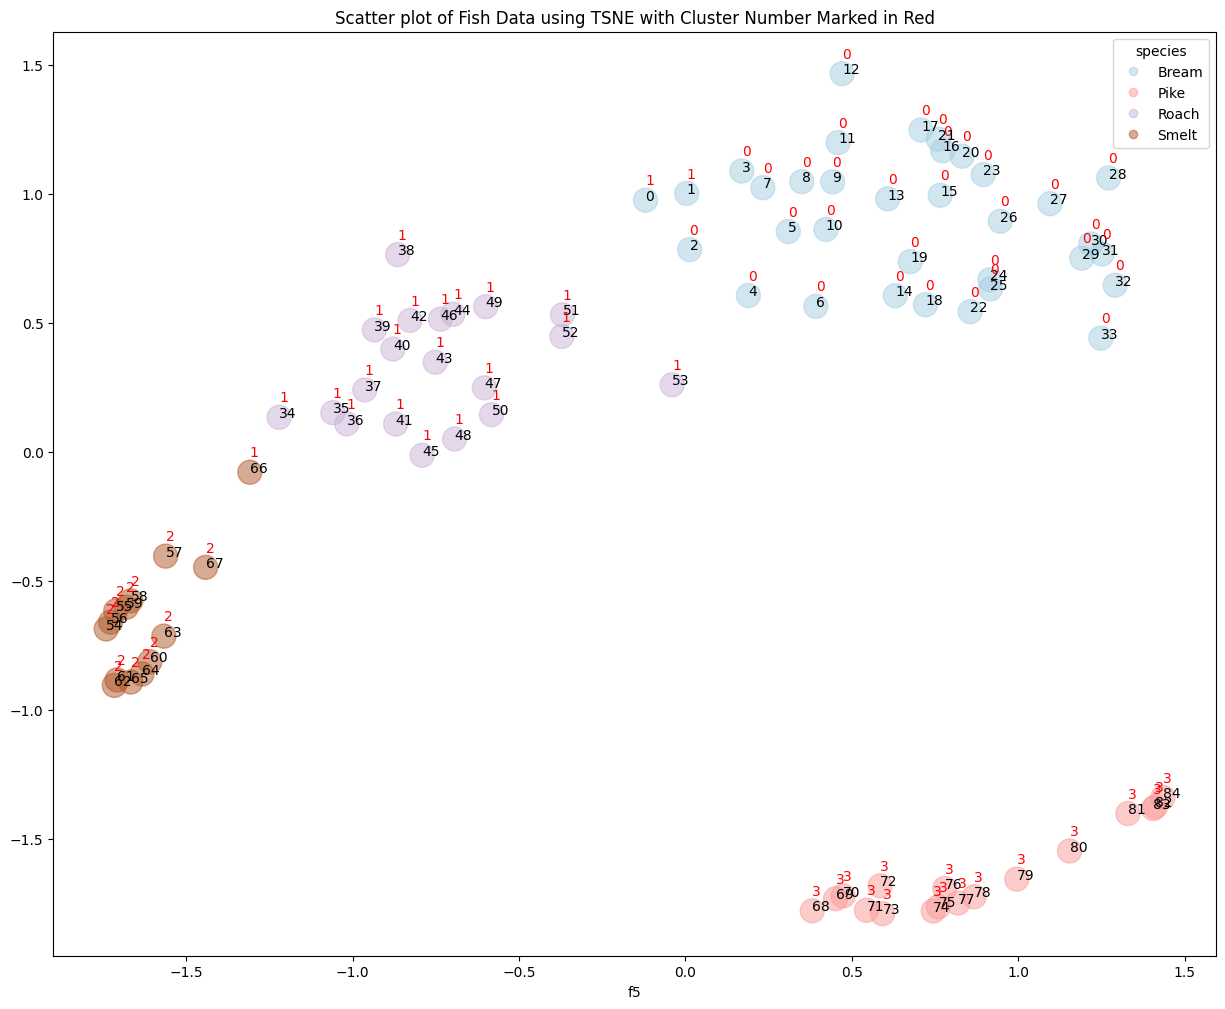

In [119]:
# TSNE PLOT AND CLUSTERS

ind = X.index.tolist()
plt.figure(figsize=(15,12))
scatter = plt.scatter(fish_df["tsne1"],fish_df["tsne2"],c=Y, cmap='Paired',s=300, alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=["Bream","Pike","Roach","Smelt"],
           title="species")
#plt.scatter(tsne_centers[:,0],tsne_centers[:,1],marker="x",s=100,c="red")
plt.title("Scatter plot of Fish Data using TSNE with Cluster Number Marked in Red")
plt.xlabel("f2")
plt.xlabel("f5")
# Loop for annotation of all points to know relative positions of points
for i in range(len(X)):
    plt.annotate(ind[i], (fish_df.loc[i,"tsne1"],fish_df.loc[i,"tsne2"]),fontsize=10,fontweight=0.3)
    plt.annotate(fish_df.loc[i,"cluster"], (fish_df.loc[i,"tsne1"],fish_df.loc[i,"tsne2"]+0.06),fontsize=10,fontweight=0.3,c="red")


plt.show()


### Observations
* From [cross tabulation](https://colab.research.google.com/drive/1z0wiq9CZ-XtLdYi515XEUfrIl6f4zgUc#scrollTo=T0TkM_-0e8De&line=1&uniqifier=1) we can see that 3 datapoints were wrongly clustered and those datapoints can be identified form scatter plot above

* The datapoint 66th, and 0th and 1st observation were wrongly classified and we can see 66th datapoint is very close to "Roach" species cluster when we see the TSNE components plot.

* In 2-D clustering we chose 2 features which were clearly separating the clusters but in 6-D clustering we can observe some amount of fuzziness.

## Conclusion

Fuzzy means clustering offer advantage while clustering fuzyz datasets and also it has fast convergence due to its objective function.

However there is certain disadvantage as the number of clusters increase the values of membership functions become very small thus, causing difficulty in assigning a particular cluster.